In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
n_rows = 7
n_cols = 10
gridworld = np.zeros((n_rows, n_cols))

In [4]:
init_pos = np.array([3, 0])
goal_pos = np.array([3, 7])

In [5]:
strength = -np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])
wind = np.c_[strength, np.zeros(n_cols)]
wind = np.zeros((n_rows, n_cols, 2)) + wind[None, ...]

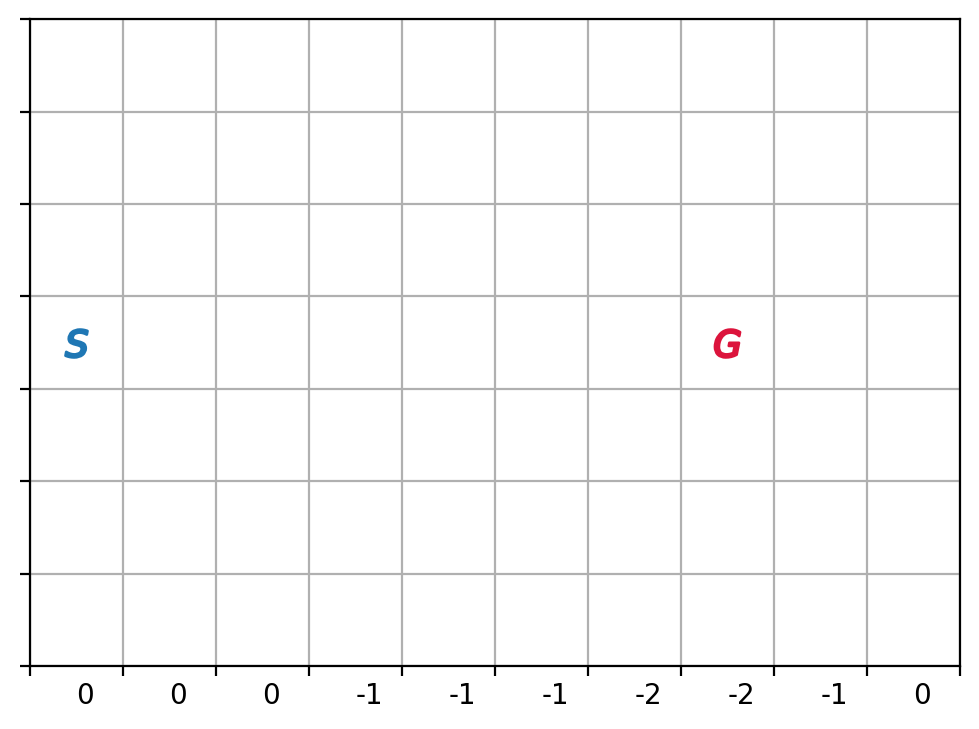

In [6]:
fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.6))
xticks = np.arange(n_cols + 1)
yticks = np.arange(n_rows + 1)

init = init_pos[::-1] + 0.5
goal = goal_pos[::-1] + 0.5
ax.scatter(*init, marker="$S$", s=100)
ax.scatter(*goal, marker="$G$", s =100, c="crimson")
# plt.scatter(*finish_pos)

ax.set_xticks(xticks, labels="")
plt.yticks(yticks, labels="")

# TODO: change for minor xticks
for x, s in enumerate(strength):
    plt.text(x + 0.5, -0.4, s)

plt.grid()

In [7]:
movements = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # up,
    [-1, 0], # down
])
n_actions = len(movements)

In [8]:
@njit
def get_probas(qval, epsilon):
    qmax = qval.max()
    n_actions = len(qval)
    mask = qmax == qval

    if np.all(mask):
        probas = np.ones(n_actions) / n_actions
    elif sum(mask) > 1:
        n_equal = sum(mask)
        probas = epsilon * np.ones(n_actions) /  n_actions
        probas = ((1 - epsilon) / n_actions + epsilon) * mask +  probas * (1 - mask)
    else:
        # return epsilon-greeedy action
        action_max = qval.argmax()
        probas = epsilon * np.ones(n_actions) / n_actions
        probas[action_max] = 1 - epsilon + epsilon / n_actions

    return probas

## Another gridworld

In [9]:
n_rows = 7
n_cols = 10
ixs = np.arange(n_rows * n_cols).reshape(n_rows, n_cols)
ixs

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]])

In [69]:
def wind_strength(n_row, n_col):
    c_strength = 0
    
    if n_col in [3, 4, 5, 8]:
        r_strength =-1
    elif n_col in [6, 7]:
        r_strength = -2
    else:
        r_strength = 0

    move_wind = np.array([r_strength, c_strength])
    return move_wind

In [70]:
# @njit
def get_pos(ix, n_cols):
    col = ix // n_cols
    row = ix % n_cols
    pos = np.array([col, row])
    return pos


# @njit
def get_ix(pos, n_cols):
    row, col = pos
    ix = row * n_cols + col
    return ix


# @njit
def move_pos(pos, step, n_row, n_cols):
    row, col = pos
    row_next, col_next = pos + step
    
    if (row_next < 0) or (row_next >= n_rows):
        row_next = row
    if (col_next < 0) or (col_next >= n_cols):
        col_next = col
    
    pos_next = np.array([row_next, col_next])
    return pos_next


# @njit
def _move(ix, step, n_rows, n_cols):
    pos = get_pos(ix, n_cols)
    pos_new = move_pos(pos, step, n_rows, n_cols)
    ix_new = get_ix(pos_new, n_cols)
    return ix_new



# move with wind
def move(ix, step, n_rows, n_cols):
    pos = get_pos(ix, n_cols)
    wind_shift = wind_strength(*pos)
    
    pos_new = move_pos(pos, step + wind_shift, n_rows, n_cols)
    
    ix_new = get_ix(pos_new, n_cols)
    return ix_new


# @njit
def move_and_reward(ix, step, n_rows, n_cols, start_state, end_state, reward_goal):
    ix_new = move(ix, step, n_rows, n_cols) # new s
    reward = -1 if ix_new != end_state else reward_goal
    ix_new = ix_new if ix_new != end_state else start_state
    return ix_new, reward


# @njit
def choose_action(ix, Q, epsilon):
    probas = get_probas(Q[ix], epsilon)
    action = np.random.multinomial(1, probas).argmax()
    return action


# @njit
def sarsa_step(s, a, Q, epsilon, n_rows, n_cols, start_state, end_state, reward_goal):
    # (s, a) -> (r, s_new, a_new)
    step = movements[action]
    s_new, r = move_and_reward(s, step, n_rows, n_cols, start_state, end_state, reward_goal)
    a_new = choose_action(s_new, Q, epsilon)

    return r, s_new, a_new

In [71]:
Q = np.zeros((n_rows * n_cols, n_actions)) # action-value function
Q.shape

(70, 4)

In [75]:
epsilon = 0.005
alpha = 0.5
gamma = 1.0
ix = 30
start_state = 30
end_state =  37 #69
action = choose_action(ix, Q, epsilon)

ix_hist = [30]
reward_hist = [0]
reward_goal = 10

for _ in range(20_000):
    r, ix_new, action_new = sarsa_step(ix, action, Q, epsilon, n_rows, n_cols, start_state, end_state, reward_goal)
    Q[ix, action] = Q[ix, action] + alpha * (r + gamma * Q[ix_new, action_new] - Q[ix, action])
    ix, action = ix_new, action_new
    ix_hist.append(ix)
    reward_hist.append(r)
ix_hist = np.array(ix_hist)
reward_hist = np.array(reward_hist)

In [76]:
ix_goal = np.where(reward_hist == reward_goal)[0]

pos_hist = np.c_[ix_hist % n_cols, ix_hist // n_cols]
distance_hist = np.abs(pos_hist - get_pos(end_state, n_cols)).sum(axis=1)

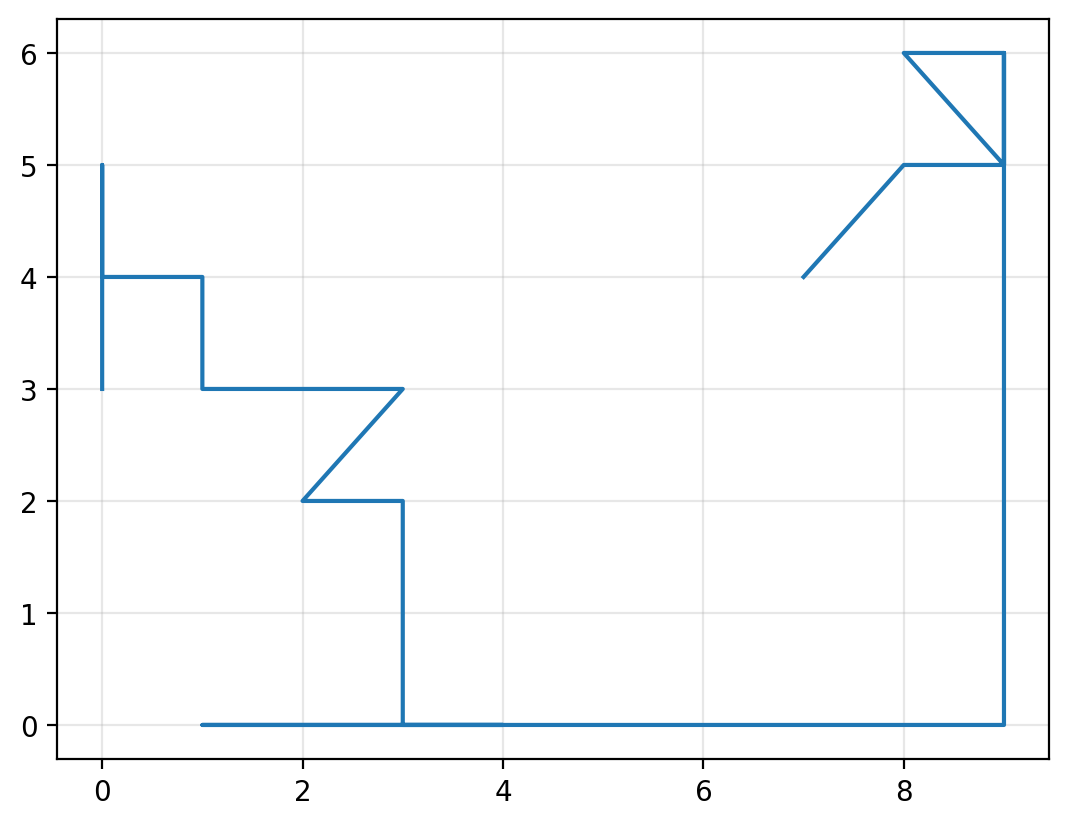

In [80]:
run = -7
iinit = ix_goal[run]
iend = ix_goal[run + 1]

plt.plot(*pos_hist[iinit:iend].T)
# plt.axhline(y=end_state)
# plt.axhline(y=30)
plt.grid(alpha=0.3)

In [61]:
distance_hist[-100:]

array([10,  9,  9,  9, 10,  9,  8,  9,  8,  7,  7,  7,  7,  7,  7, 10,  9,
       10, 11, 12, 11, 10,  9,  8,  7, 12, 11, 10,  9, 10,  9,  9,  9,  9,
        9,  9, 10, 11, 12, 11, 10,  9,  8,  7, 12, 13, 12, 11, 12, 13, 14,
       14, 14, 15, 14, 13, 13, 13, 14, 13, 14, 13, 12, 11, 11, 11, 11, 10,
        9, 10,  9, 10, 11, 12, 11, 10,  9,  8,  7, 12, 11, 10,  9,  8,  9,
        8,  8,  8,  7,  6,  8, 10, 10, 10, 10, 12, 11, 11, 11, 10])

In [62]:
ix_hist[-100:]

array([50, 60, 60, 60, 50, 51, 52, 51, 52, 53, 44, 35, 26, 26, 26,  5,  6,
        7,  8,  9, 19, 29, 39, 49, 59, 30, 31, 32, 42, 32, 33, 24, 24, 24,
       15,  6,  7,  8,  9, 19, 29, 39, 49, 59, 30, 20, 21, 22, 12,  2,  1,
        1,  1,  0, 10, 20, 20, 20, 10, 11,  1,  2, 12, 13, 13, 13,  4,  5,
        6,  5,  6,  7,  8,  9, 19, 29, 39, 49, 59, 30, 40, 50, 60, 61, 51,
       61, 61, 61, 62, 63, 43, 23, 23, 23, 14,  3,  4,  4,  4,  5])

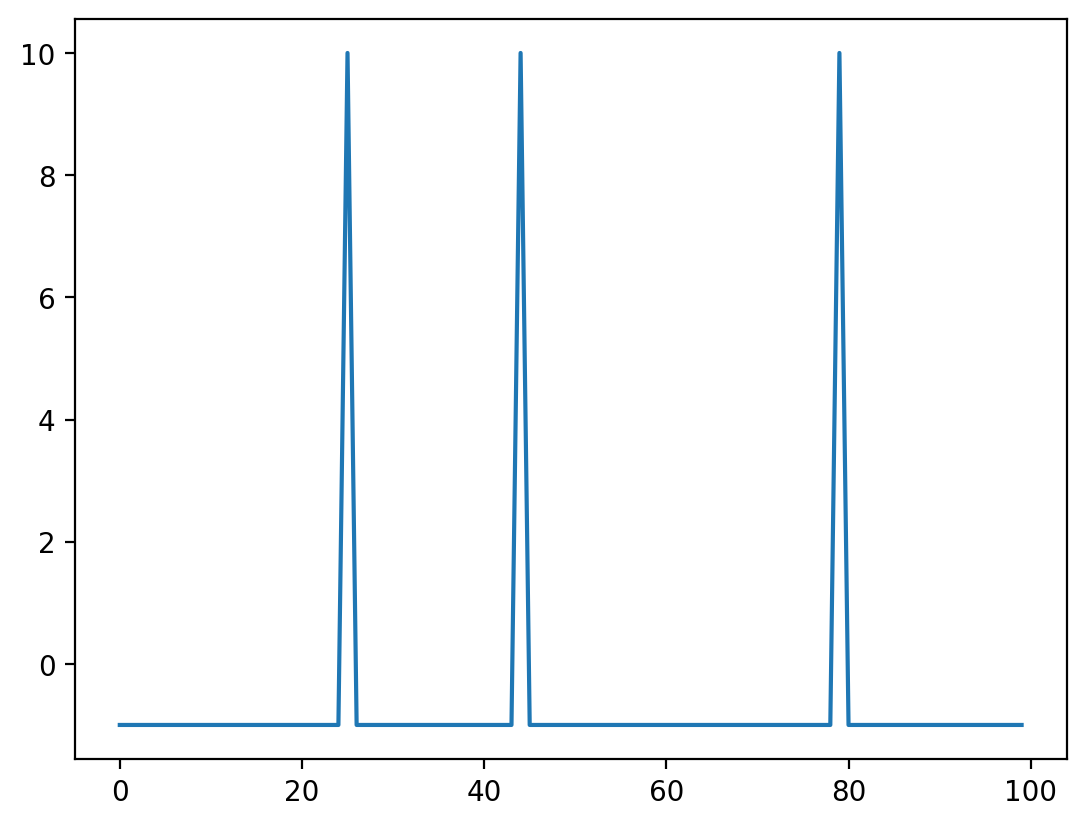

In [63]:
plt.plot(reward_hist[-100:])

In [64]:
ix_goal

array([ 1515,  1670,  1880,  2148,  2180,  2328,  2382,  2449,  2643,
        2669,  2710,  2747,  2832,  2853,  2878,  2905,  3016,  3050,
        3077,  3119,  3200,  3236,  3296,  3344,  3422,  3446,  3474,
        3517,  3546,  3595,  3618,  3639,  3688,  3718,  3739,  3783,
        3829,  3865,  3898,  3927,  3944,  3959,  3986,  4009,  4084,
        4103,  4126,  4161,  4178,  4197,  4217,  4237,  4260,  4291,
        4322,  4349,  4372,  4394,  4421,  4442,  4466,  4497,  4512,
        4546,  4572,  4587,  4623,  4657,  4701,  4723,  4752,  4806,
        4837,  4861,  4896,  4925,  4995,  5014,  5047,  5121,  5146,
        5177,  5220,  5241,  5279,  5317,  5361,  5381,  5430,  5464,
        5501,  5546,  5569,  5600,  5640,  5674,  5720,  5773,  5804,
        5836,  5872,  5894,  5925,  5979,  6018,  6085,  6109,  6151,
        6185,  6226,  6300,  6321,  6354,  6382,  6402,  6436,  6491,
        6531,  6574,  6616,  6646,  6676,  6703,  6728,  6754,  6782,
        6818,  6854,

In [65]:
(reward_hist == reward_goal).sum()

503

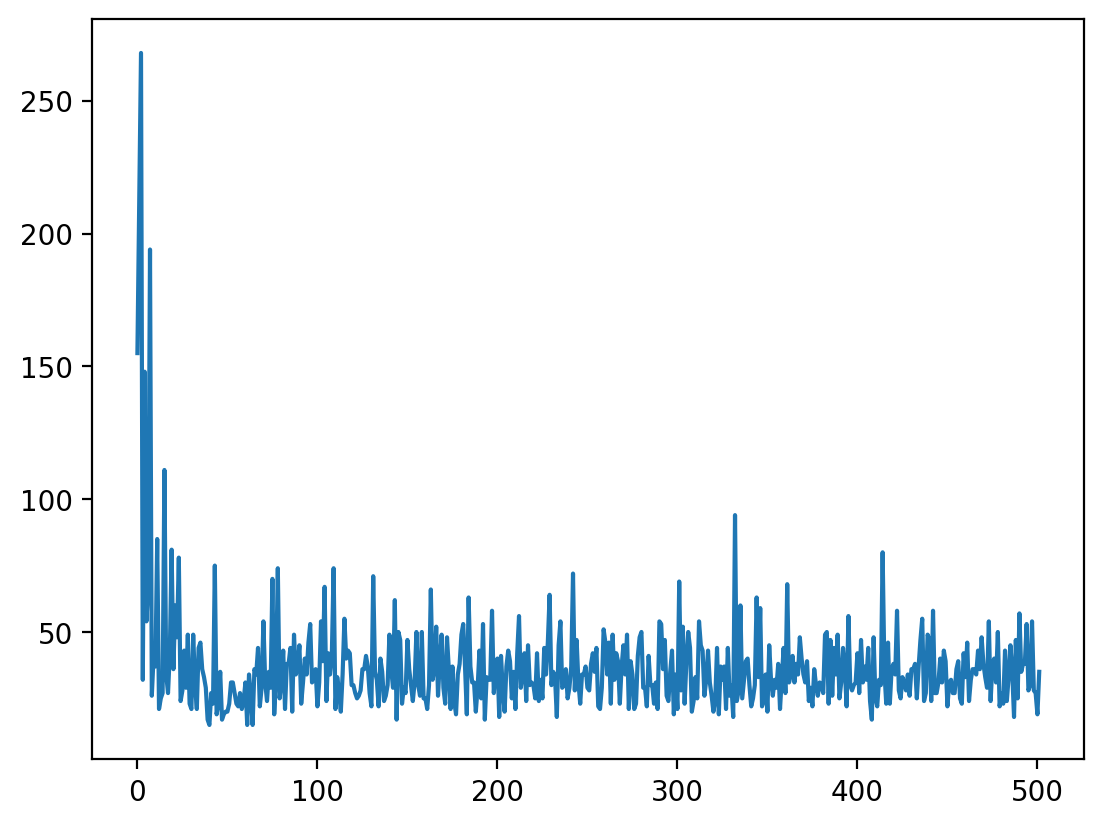

In [66]:
plt.plot(np.diff(ix_goal))
# plt.yscale("log")

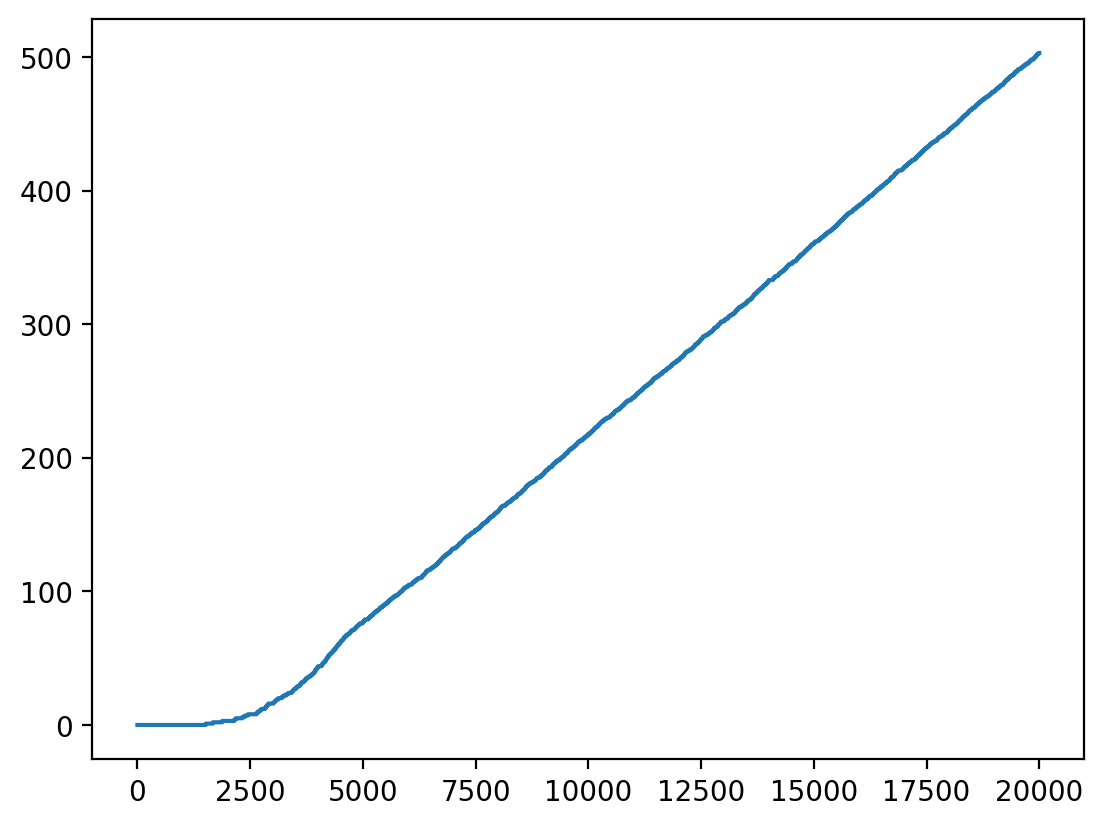

In [67]:
plt.plot((reward_hist == reward_goal).cumsum())